In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
import keras

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

from sklearn.model_selection import ShuffleSplit

test_images_dir = '/home/sichun1247/Sampled_Test/'
train_images_dir = '/home/sichun1247/Sampled_Train/'

/home/sichun1247/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def read_testset(filename="/home/sichun1247/test_sample.csv"):
    df = pd.read_csv(filename)

    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

def read_trainset(filename="/home/sichun1247/train_sample.csv"):
    df = pd.read_csv(filename)

    
    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

train_df = read_trainset()   
test_df = read_testset()

In [3]:
import os
dirct = os.listdir('/home/sichun1247/Sampled_Train')
train_ID = []
for f_name in dirct:
    if f_name.endswith('.dcm'):
        f, _ = f_name.split('.')
        train_ID.append(f)

In [4]:
import os
dirct = os.listdir('/home/sichun1247/Sampled_Test')
test_ID = []
for f_name in dirct:
    if f_name.endswith('.dcm'):
        f, _ = f_name.split('.')
        test_ID.append(f)

In [5]:
tt = np.load('train1.npy')
pp = np.load('train2.npy')
p_train = []
for item in tt:
    p_train.append(item)
for item in pp:
    p_train.append(item)
test = np.load('test.npy')
p_test = []
for item in test:
    p_test.append(item)
l_train =  list(zip(train_ID, p_train))
l_test =  list(zip(test_ID, p_test))

In [6]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [10]:
def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

In [11]:
def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

In [3]:
#train_images_dir = '/home/sichun1247/stage_1_train_images/'

In [4]:
#dicom = pydicom.dcmread(train_images_dir + 'ID_036db39b7' + '.dcm')

In [5]:
#print(dicom)

(0008, 0018) SOP Instance UID                    UI: ID_036db39b7
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_657b33db'
(0020, 000d) Study Instance UID                  UI: ID_bcb282cac7
(0020, 000e) Series Instance UID                 UI: ID_7fba670739
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-17.3514035', '162.459298']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.961261696', '-0.275637356']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         

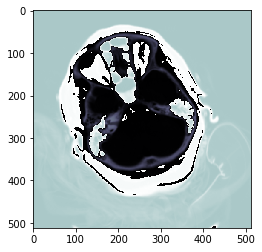

In [7]:
plt.imshow(dicom.pixel_array, cmap=plt.cm.bone)

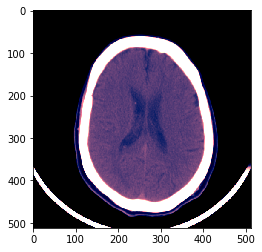

In [0]:
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone)

In [12]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
#plt.imshow(
#    _read(train_images_dir+'ID_00c7ee95d'+'.dcm', (128, 128)), cmap=plt.cm.bone
# );

In [3]:
tt = np.load('train1.npy')
pp = np.load('train2.npy')
p_train = []
for item in tt:
    p_train.append(item)
for item in pp:
    p_train.append(item)
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
train_images_ID = [s.strip('.dcm') for s in train_images]
l_train =  list(zip(train_images_ID, p_train))
#train_pixel = pd.DataFrame(l_train, columns = ['ID_Image' , 'pixel']) 

In [4]:
test = np.load('test.npy')
p_test = []
for item in test:
    p_test.append(item)
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
test_images_ID = [s.strip('.dcm') for s in test_images]
l_test =  list(zip(test_images_ID, p_test))
# test_pixel = pd.DataFrame(l_test, columns = ['ID_Image' , 'pixel'])
# given ID read pixel ID_a0d12bb79
#[x[1] for x in l_test if x[0] == 'ID_a0d12bb79']

In [15]:
a = _read('/home/sichun1247/Sampled_Test/'+'ID_a0d12bb79'+".dcm", (128,128,3))

In [16]:
np.shape(a)

(128, 128, 3)

In [19]:
b = [x[1] for x in l_test if x[0] == 'ID_a0d12bb79'][0]

In [20]:
np.shape(b)

(128, 128, 3)

In [14]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=train_images_dir, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                #X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                X[i,] = [x[1] for x in l_train if x[0] == ID][0]
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            if self.img_dir == '/home/sichun1247/Sampled_Test/':
                for i, ID in enumerate(list_IDs_temp):
                    #X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                    X[i,] = [x[1] for x in l_test if x[0] == ID][0]
            else:
                for i, ID in enumerate(list_IDs_temp):
                    #X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                    X[i,] = [x[1] for x in l_train if x[0] == ID][0]
            
            return X

In [8]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [9]:
class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(224, 224, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])
        
        # Commented out to save time
        self.valid_predictions.append(
             self.model.predict_generator(
                 DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir), verbose=2)[:len(self.valid_df)])
        
        print("validation loss: %.4f" %
              weighted_log_loss_metric(self.valid_df.values, 
                                  np.average(self.valid_predictions, axis=0, 
                                              weights=[2**i for i in range(len(self.valid_predictions))])))
        
        print("Test loss: %.4f" %
              weighted_log_loss_metric(self.test_df.values, 
                                  np.average(self.test_predictions, axis=0, 
                                              weights=[2**i for i in range(len(self.test_predictions))])))
        
        # here you could also save the predictions with np.save()


In [10]:
class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
#         x = keras.layers.Dropout(0.2)(x)
#         x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
#         x = keras.layers.Dropout(0.1)(x)
        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)

        self.model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[weighted_loss])
    

    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpointer = keras.callbacks.ModelCheckpoint(filepath='%s-{epoch:02d}.hdf5' % self.engine.__name__, verbose=1, save_weights_only=True, save_best_only=False)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

In [11]:
test_df = test_df
df = train_df

In [15]:
# train set (00%) and validation set (10%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)

# obtain model
model = MyDeepModel(engine=InceptionV3, input_dims=(128, 128, 3), batch_size=32, learning_rate=5e-4,
                    num_epochs=10, decay_rate=0.8, decay_steps=1, weights=None, verbose=1)

# obtain test + validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)

Epoch 1/10
1678/1678 [==============================] - 4930s 3s/step - loss: 0.3454 - weighted_loss: 0.3633
validation loss: 0.3005
Test loss: 0.3315
Epoch 2/10
1678/1678 [==============================] - 5067s 3s/step - loss: 0.2917 - weighted_loss: 0.3051
validation loss: 0.3074
Test loss: 0.3269
Epoch 3/10
1674/1674 [==============================] - 5251s 3s/step - loss: 0.2683 - weighted_loss: 0.2801
validation loss: 0.2515
Test loss: 0.2840
Epoch 4/10
1677/1677 [==============================] - 5213s 3s/step - loss: 0.2481 - weighted_loss: 0.2586
validation loss: 0.2465
Test loss: 0.2672
Epoch 5/10
1672/1672 [==============================] - 4910s 3s/step - loss: 0.2316 - weighted_loss: 0.2405
validation loss: 0.2290
Test loss: 0.2526
Epoch 6/10
1686/1686 [==============================] - 5014s 3s/step - loss: 0.2159 - weighted_loss: 0.2244
validation loss: 0.2167
Test loss: 0.2482
Epoch 7/10
1681/1681 [==============================] - 4938s 3s/step - loss: 0.2029 - weighte